# Variational autoencoders for missing data completion and denoising of neuroimaging data

Variational autoencoders have been demonstrated to be powerful generative models for learning a lower-dimensional latent distribution of high dimensional data and then generate data from that distribution. This has numerous applications such as denoising documents or audio, or even generating faces and music. Its application in neuroimaging have been limited, however, due to lack of large datasets. Neuroimaging data is 3D, adding another layer of complexity.

Neuroimaging data is mired with signal artifacts induced by motion, inhomogeneties in the magnetic field, even field-of-view issues causing cropping and loss of data. In diffusion imaging, signal dropout is very common and is usually an important quality control metric that can determine whether a subject is included or not. In fact, distortion removal pipelines typically require a separate scan in the opposite phase encoding direction, which is usually not acquired due to time or funding constraints. Thus, many diffusion images contain significant distortions in brain voxels, especially near the cerebellum and frontal cortex. The presence of numerous artifacts, on top of the difficulty in acquiring subjects for a neuroimaging study, make it very challenging to compile a large clean neuroimaging dataset and test generalizable hypotheses about the brain's structure and function.

Here, we will attempt to recover lost signal due to field-of-view/cropping issues in DTI data using variational autoencoders. We will try to extend this to clean other artifacts in DTI data, such as signal dropout and distortions. We've demonstrated in a previous notebook that we can denoise 2D image data with VAEs. We simply need to extend this to 3D images.

First, we must load a DWI file from a subject. Each file has several volumes corresponding with a certain b-value. We will first train on b0 volumes. Let's see how we can load one...

## Load libraries and file paths

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn.plotting import plot_anat
from nilearn.image import index_img

# load list of subject DWI files
dwi_files = np.loadtxt('dwi_file_list.txt', dtype=str)
# create list of subject bval files
bvals = [file[:-7] + '.bval' for file in dwi_files]

# Extract indices of image corresponding to b0 volumes
def getb0(bval_file):
    b = np.loadtxt(bval_file)
    # The b0 volumes in HCP data actually have a value of 5, so check both 0 and 5
    b_ind = np.concatenate((np.where(b == 5)[0], np.where(b == 0)[0]))
    return b_ind

# Dictionary that maps file name to indices of where the b0 volumes are within each file
dwi2b0 = {dwi_files[ind] : getb0(file) for ind,file in enumerate(bvals)}

## Visualize a random sample image

In [2]:
# Takes an image file and the map from filename to indices of b0 volumes to load the right image data
def loadb0(img_file, file2b_ind, as_type = 'nib', normalize = True):
    # as_type should either be nib for nibabel format or np for numpy array
    if as_type not in ['nib', 'np']:
        raise TypeError('Incorrect option for as_type. Use either nib or np.')
    # Load image
    img = nib.load(img_file)
    # Remove non b0 volumes
    img_fixed = img.get_fdata()[:,:,:,file2b_ind[img_file]]
    # Normalize intensity to range of 0 to 1
    if normalize:
        img_fixed = (img_fixed - np.min(img_fixed, axis = (0,1,2))) / (np.max(img_fixed, axis = (0,1,2)) - np.min(img_fixed, axis = (0,1,2)))
    if as_type == 'np':
        return img_fixed
    elif as_type == 'nib':
        # Reform as image data type
        img_fixed = nib.Nifti1Image(img_fixed, np.eye(4))
        return img_fixed

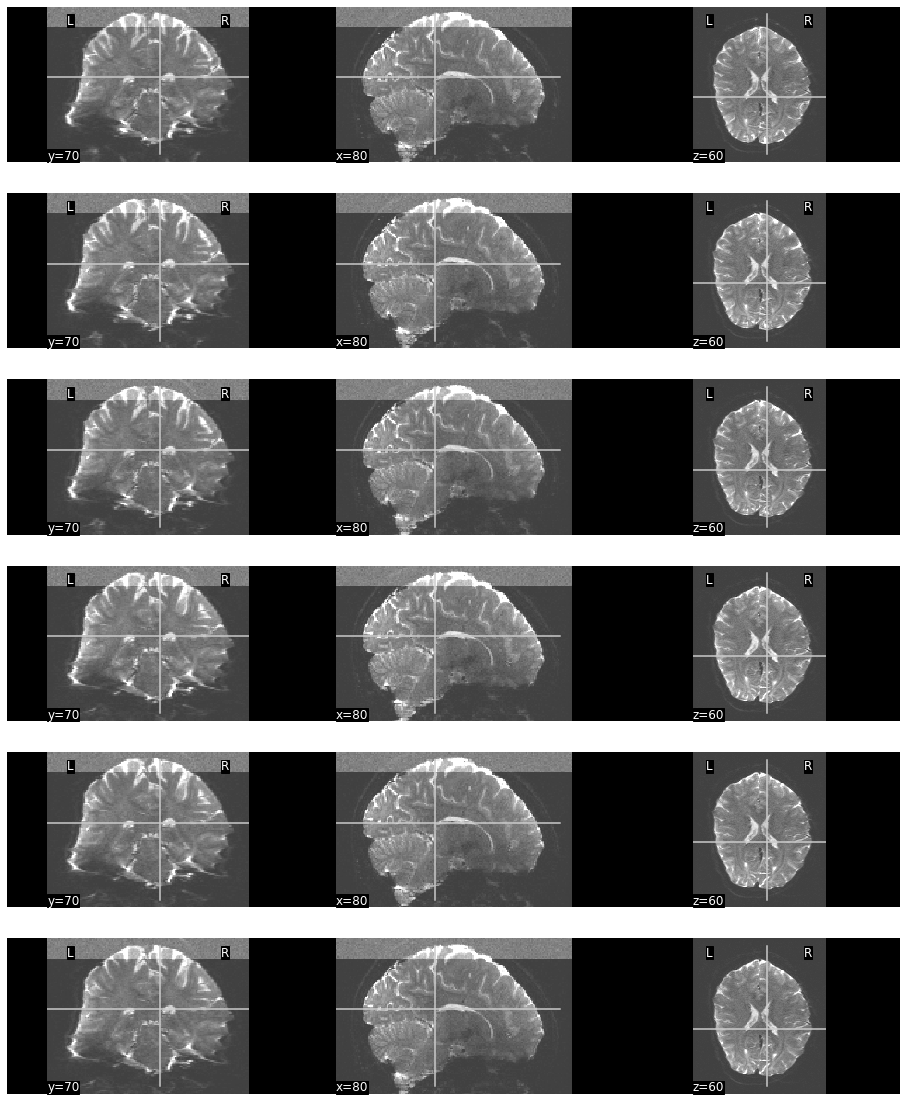

In [16]:
# Random file
idx = np.random.choice(dwi_files.shape[0], 1)[0]
dwi = loadb0(dwi_files[0], dwi2b0)
dwi = dwi.get_fdata()
dwi[:,:,-15:,:] = dwi[:,:,-15:,:] + np.random.normal(0.1, 0.01, size = dwi[:,:,-15:,:].shape)
dwi = nib.Nifti1Image(dwi, np.eye(4))
num_vol = dwi.shape[-1]
plt.close('all')
fig,ax = plt.subplots(num_vol,1, figsize = (16,20))
for i in range(num_vol):
    # Plot all b0 volumes, intensity scaled such that we can see the skull clearly
    plot_anat(index_img(dwi, i), axes = ax[i], vmin = -0.1, vmax = 0.3, cut_coords = (80,70,60))
plt.show()

## Data augmentation

Let's see if we can simply reconstruct the 3D images with a VAE. We will need to perform data augmentation to expand our training set. We can do this by adding small rotations, translations, adding noise, or changing brightness and contrast. Let's create a function that can perform this and test it on a sample image.

Adding rotation
Adding translation
Adding noise


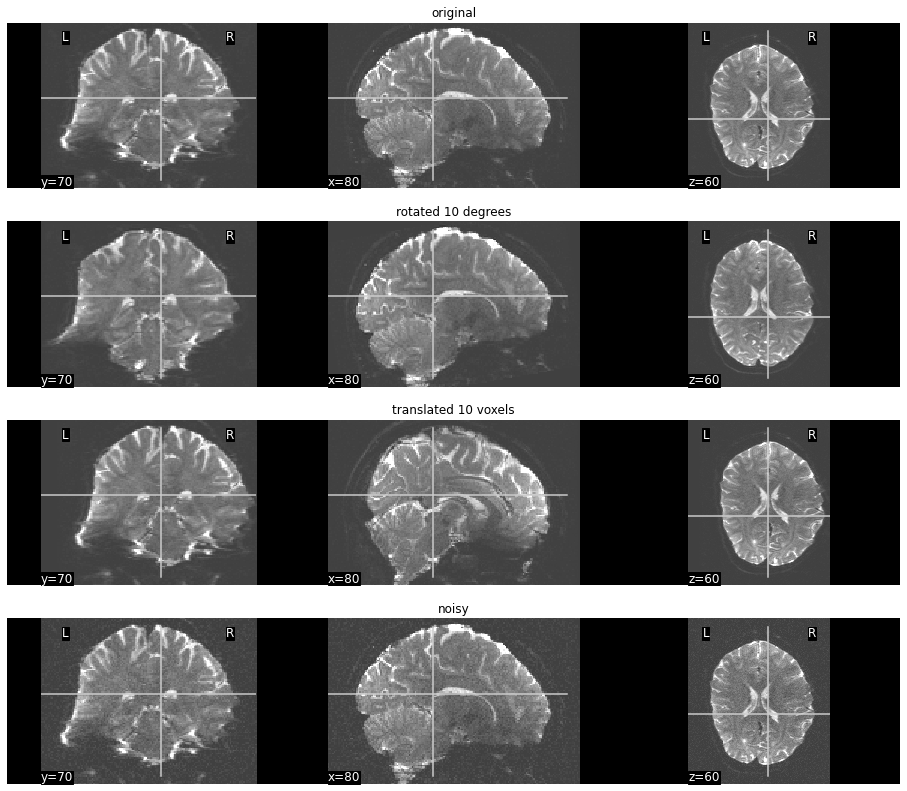

In [17]:
from scipy.ndimage import rotate, shift
from skimage.util import random_noise

def add_rotation(image3d, amount, axis):
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img = image3d.get_fdata()
    else:
        img = np.array(image3d)
    
    axes = [0,1,2]
    axes.remove(axis)
    # Apply rotation
    img_rotated = rotate(img, amount, axes = tuple(axes), reshape = False)
    
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img_rotated = nib.Nifti1Image(img_rotated, np.eye(4))
    
    return img_rotated

def add_translation(image3d, amount, axis):
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img = image3d.get_fdata()
    else:
        img = np.array(image3d)
        
    shift_apply = np.zeros((3,))
    shift_apply[axis] = amount
    # Apply translation
    img_translated = shift(img, shift_apply)
    
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img_translated = nib.Nifti1Image(img_translated, np.eye(4))
        
    return img_translated

def add_noise(image3d, amount = 0.0001):
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img = image3d.get_fdata()
    else:
        img = np.array(image3d)
    
    noisy_img = random_noise(img, mode = 'gaussian', clip = True, var = amount)
    
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        noisy_img = nib.Nifti1Image(noisy_img, np.eye(4))
    
    return noisy_img

idx = np.random.choice(dwi_files.shape[0], 1)[0]
dwi = loadb0(dwi_files[0], dwi2b0)
print('Adding rotation')
dwi_rotated = add_rotation(index_img(dwi,0), 10, 0)
print('Adding translation')
dwi_translated = add_translation(index_img(dwi,0), 10, 0)
print('Adding noise')
dwi_noisy = add_noise(index_img(dwi,0))

plt.close('all')
fig,ax = plt.subplots(4,1, figsize = (16,14))
plot_anat(index_img(dwi, 0), axes = ax[0], vmin = -0.1, vmax = 0.3, cut_coords = (80,70,60))
ax[0].set_title('original')
plot_anat(dwi_rotated, axes = ax[1], vmin = -0.1, vmax = 0.3, cut_coords = (80,70,60))
ax[1].set_title('rotated 10 degrees')
plot_anat(dwi_translated, axes = ax[2], vmin = -0.1, vmax = 0.3, cut_coords = (80,70,60))
ax[2].set_title('translated 10 voxels')
plot_anat(dwi_noisy, axes = ax[3], vmin = -0.1, vmax = 0.3, cut_coords = (80,70,60))
ax[3].set_title('noisy')
plt.show()

Now we are ready to put our loading and data augmentation functions to use. We could perform live data augmentation - that is, we modify data as we read them, not physically expanding the dataset. However, reading neuroimaging files and process them takes way too long and we don't want to burn training time continuously loading from the disk. Instead, we will perform all the augmentations and store the full dataset on disk. With augmentation, there should be about 8400 samples (6 possible rotations, 6 possible translations, 1 noise, meaning 600 + 14 = 8400 images) times 6 b0 volumes per image meaning about 50,400 training samples total. This will take about 1 TB of space... good thing we're on Sherlock and I have a quota of 100 TB!

In [5]:
file_list = []
for ind,file_path in enumerate(dwi_files):
    #if ind < 130: continue
    #print('Augmenting ' + file_path)
    print('Processing %d of %d files' % ((ind + 1), dwi_files.shape[0]))
    subj = file_path.split('/')[1]
    dwi = loadb0(file_path, dwi2b0, as_type = 'np')
    # Use each b0 volume as an independent input
    for b0 in range(dwi.shape[-1]):
        #print('\tb0 volume %d out of %d' % ((b0+1),dwi.shape[-1]))
        # Original file
        prefix = 'traindata/' + subj + '/' + file_path.split('/')[-1][:-7] + '_b0vol' + str(b0+1)
        savename = prefix + '_original.npy'
        np.save(savename, dwi[:,:,:,b0])
        file_list.append(savename)
        # Rotate and translate
        i = 1
        for amount in [-10, 10]:
            for axis in [0,1,2]:
                dwi_preprocess = add_rotation(dwi[:,:,:,b0], amount, axis)
                savename = prefix + '_rotate' + str(i) + '.npy'
                np.save(savename, dwi_preprocess)
                file_list.append(savename)
                dwi_preprocess = add_translation(dwi[:,:,:,b0], amount, axis)
                savename = prefix + '_translate' + str(i) + '.npy'
                np.save(savename, dwi_preprocess)
                file_list.append(savename)
                i += 1
        # Noise
        dwi_preprocess = add_noise(dwi[:,:,:,b0])
        savename = prefix + '_noisy.npy'
        np.save(savename, dwi_preprocess)
        file_list.append(savename)
print('Number of training samples: ' + str(len(file_list)))

Processing 131 of 594 files
Processing 132 of 594 files
Processing 133 of 594 files
Processing 134 of 594 files
Processing 135 of 594 files
Processing 136 of 594 files
Processing 137 of 594 files
Processing 138 of 594 files
Processing 139 of 594 files
Processing 140 of 594 files
Processing 141 of 594 files
Processing 142 of 594 files
Processing 143 of 594 files
Processing 144 of 594 files
Processing 145 of 594 files
Processing 146 of 594 files
Processing 147 of 594 files
Processing 148 of 594 files
Processing 149 of 594 files
Processing 150 of 594 files
Processing 151 of 594 files
Processing 152 of 594 files
Processing 153 of 594 files
Processing 154 of 594 files
Processing 155 of 594 files
Processing 156 of 594 files
Processing 157 of 594 files
Processing 158 of 594 files
Processing 159 of 594 files
Processing 160 of 594 files
Processing 161 of 594 files
Processing 162 of 594 files
Processing 163 of 594 files
Processing 164 of 594 files
Processing 165 of 594 files
Processing 166 of 59

Processing 424 of 594 files
Processing 425 of 594 files
Processing 426 of 594 files
Processing 427 of 594 files
Processing 428 of 594 files
Processing 429 of 594 files
Processing 430 of 594 files
Processing 431 of 594 files
Processing 432 of 594 files
Processing 433 of 594 files
Processing 434 of 594 files
Processing 435 of 594 files
Processing 436 of 594 files
Processing 437 of 594 files
Processing 438 of 594 files
Processing 439 of 594 files
Processing 440 of 594 files
Processing 441 of 594 files
Processing 442 of 594 files
Processing 443 of 594 files
Processing 444 of 594 files
Processing 445 of 594 files
Processing 446 of 594 files
Processing 447 of 594 files
Processing 448 of 594 files
Processing 449 of 594 files
Processing 450 of 594 files
Processing 451 of 594 files
Processing 452 of 594 files
Processing 453 of 594 files
Processing 454 of 594 files
Processing 455 of 594 files
Processing 456 of 594 files
Processing 457 of 594 files
Processing 458 of 594 files
Processing 459 of 59

## Image reconstruction

#### GPU configuration

In [21]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

tfback._get_available_gpus()

AttributeError: module 'tensorflow_core._api.v2.config' has no attribute 'experimental_list_devices'

In [20]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU')]

In [3]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

_get_available_gpus()

tf.__version__ is 2.0.0
tf.keras.__version__ is: 2.2.4-tf


['/job:localhost/replica:0/task:0/device:XLA_GPU:0',
 '/job:localhost/replica:0/task:0/device:XLA_GPU:1']

In [2]:
tf.test.is_gpu_available()

True

In [3]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Apr_24_19:10:27_PDT_2019
Cuda compilation tools, release 10.1, V10.1.168


#### Generator for loading batches

Now that all the files are saved on the server, we can create a generator function to load them in batches so we don't load all 1 TB into memory at once.

In [6]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn.plotting import plot_anat
from nilearn.image import index_img

# ===============================================================
# Specify these, recall that there are about 50000 total samples
# ===============================================================
num_train = 40000
batch_size = 16
crop = True
# ===============================================================
# end
# ===============================================================

"""
Generator function that loads a batch of nifti images as numpy arrays
"""
def image_generator_augmented(file_list, batch_size = 64, crop = False):
    while True:
        # Randomly choose files for the batch
        batch_paths = np.random.choice(a = file_list, size = batch_size)
        batch_input = []
        batch_output = []
        
        # Read in each file, preprocess
        for file_path in batch_paths:
            dwi = np.load(file_path).astype(np.float32)
            if crop:
                dwi_pad = dwi[:,:,-48:, np.newaxis]
            else:
                # Zero pad to make z-dimension divisible by 2, will make convolutional layers work better
                dwi_pad = np.pad(dwi,pad_width=((0,0),(0,0),(0,1)))[:,:,:,np.newaxis]
            batch_input.append(dwi_pad)
            batch_output.append(dwi_pad)
        
        # Return a tuple of (input, output) to feed the network
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        yield (batch_x, batch_y)

dwi_files_npy = np.loadtxt('X_files.txt', dtype=str)
num_val = dwi_files_npy.shape[0] - num_train
print('Number of total examples in dataset: ' + str(dwi_files_npy.shape[0]))
print('\tTraining size: ' + str(num_train))
print('\tValidation size: ' + str(num_val))
costco_sample = next(image_generator_augmented(dwi_files_npy, batch_size = batch_size, crop = crop))
print('Example batch x shape: ' + str(costco_sample[0].shape))
print('Example batch y shape: ' + str(costco_sample[1].shape))
_, image_x, image_y, image_z, image_c = costco_sample[0].shape
del costco_sample

train_data_gen = image_generator_augmented(dwi_files_npy[:num_train], batch_size = batch_size, crop = crop)
val_data_gen = image_generator_augmented(dwi_files_npy[num_train:], batch_size = batch_size, crop = crop)
val_steps = np.ceil(num_val / batch_size)
train_steps = np.ceil(num_train / batch_size)

OSError: X_files.txt not found.

#### Construct model

We're finally ready to create the model and begin training!

In [7]:
from keras.models import Model
from keras.layers import Dense, Flatten, UpSampling3D, Input, Lambda, Reshape, ZeroPadding3D
from keras.layers import Conv3D, MaxPooling3D, Conv3DTranspose
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

def sampling(args):
    mu, sigma = args
    batch_size = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape = (batch_size, dim))
    return mu + K.exp(sigma * 0.5) * eps

# ===============================================================
# Specify these beforehand
# ===============================================================
num_filters = 4 # starting number of filters
latent_dim = 16 # dimensionality of latent space
conv_kernel_size = 3
pool_kernel_size = 2
conv_strides = 2
image_x, image_y, image_z, image_c = 144, 168, 48, 1
# ===============================================================
# end
# ===============================================================

In [8]:
# Delete existing model and clear session
K.clear_session()

# Encoder
inputs = Input(shape=(image_x, image_y, image_z, image_c))
x = inputs
for i in range(2):
    filters = num_filters * (2 ** i)
    x = Conv3D(filters=filters,
               kernel_size=conv_kernel_size,
               activation='relu',
               strides=conv_strides,
               padding='same')(x)
    #x = MaxPooling3D(pool_size = pool_kernel_size)(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(latent_dim*2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae3d_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3] * shape[4], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3], shape[4]))(x)

for i in range(2):
    filters = num_filters * (2 ** (2-i))
    x = Conv3DTranspose(filters=filters,
                        kernel_size=conv_kernel_size,
                        activation='relu',
                        strides=conv_strides,
                        padding='same')(x)
    #x = UpSampling3D(size = pool_kernel_size)(x)
    

outputs = Conv3DTranspose(filters=1,
                          kernel_size=conv_kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae3d_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 144, 168, 48, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 72, 84, 24, 4 112         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 36, 42, 12, 8 872         conv3d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 145152)       0           conv3d_2[0][0]                   
____________________________________________________________________________________________

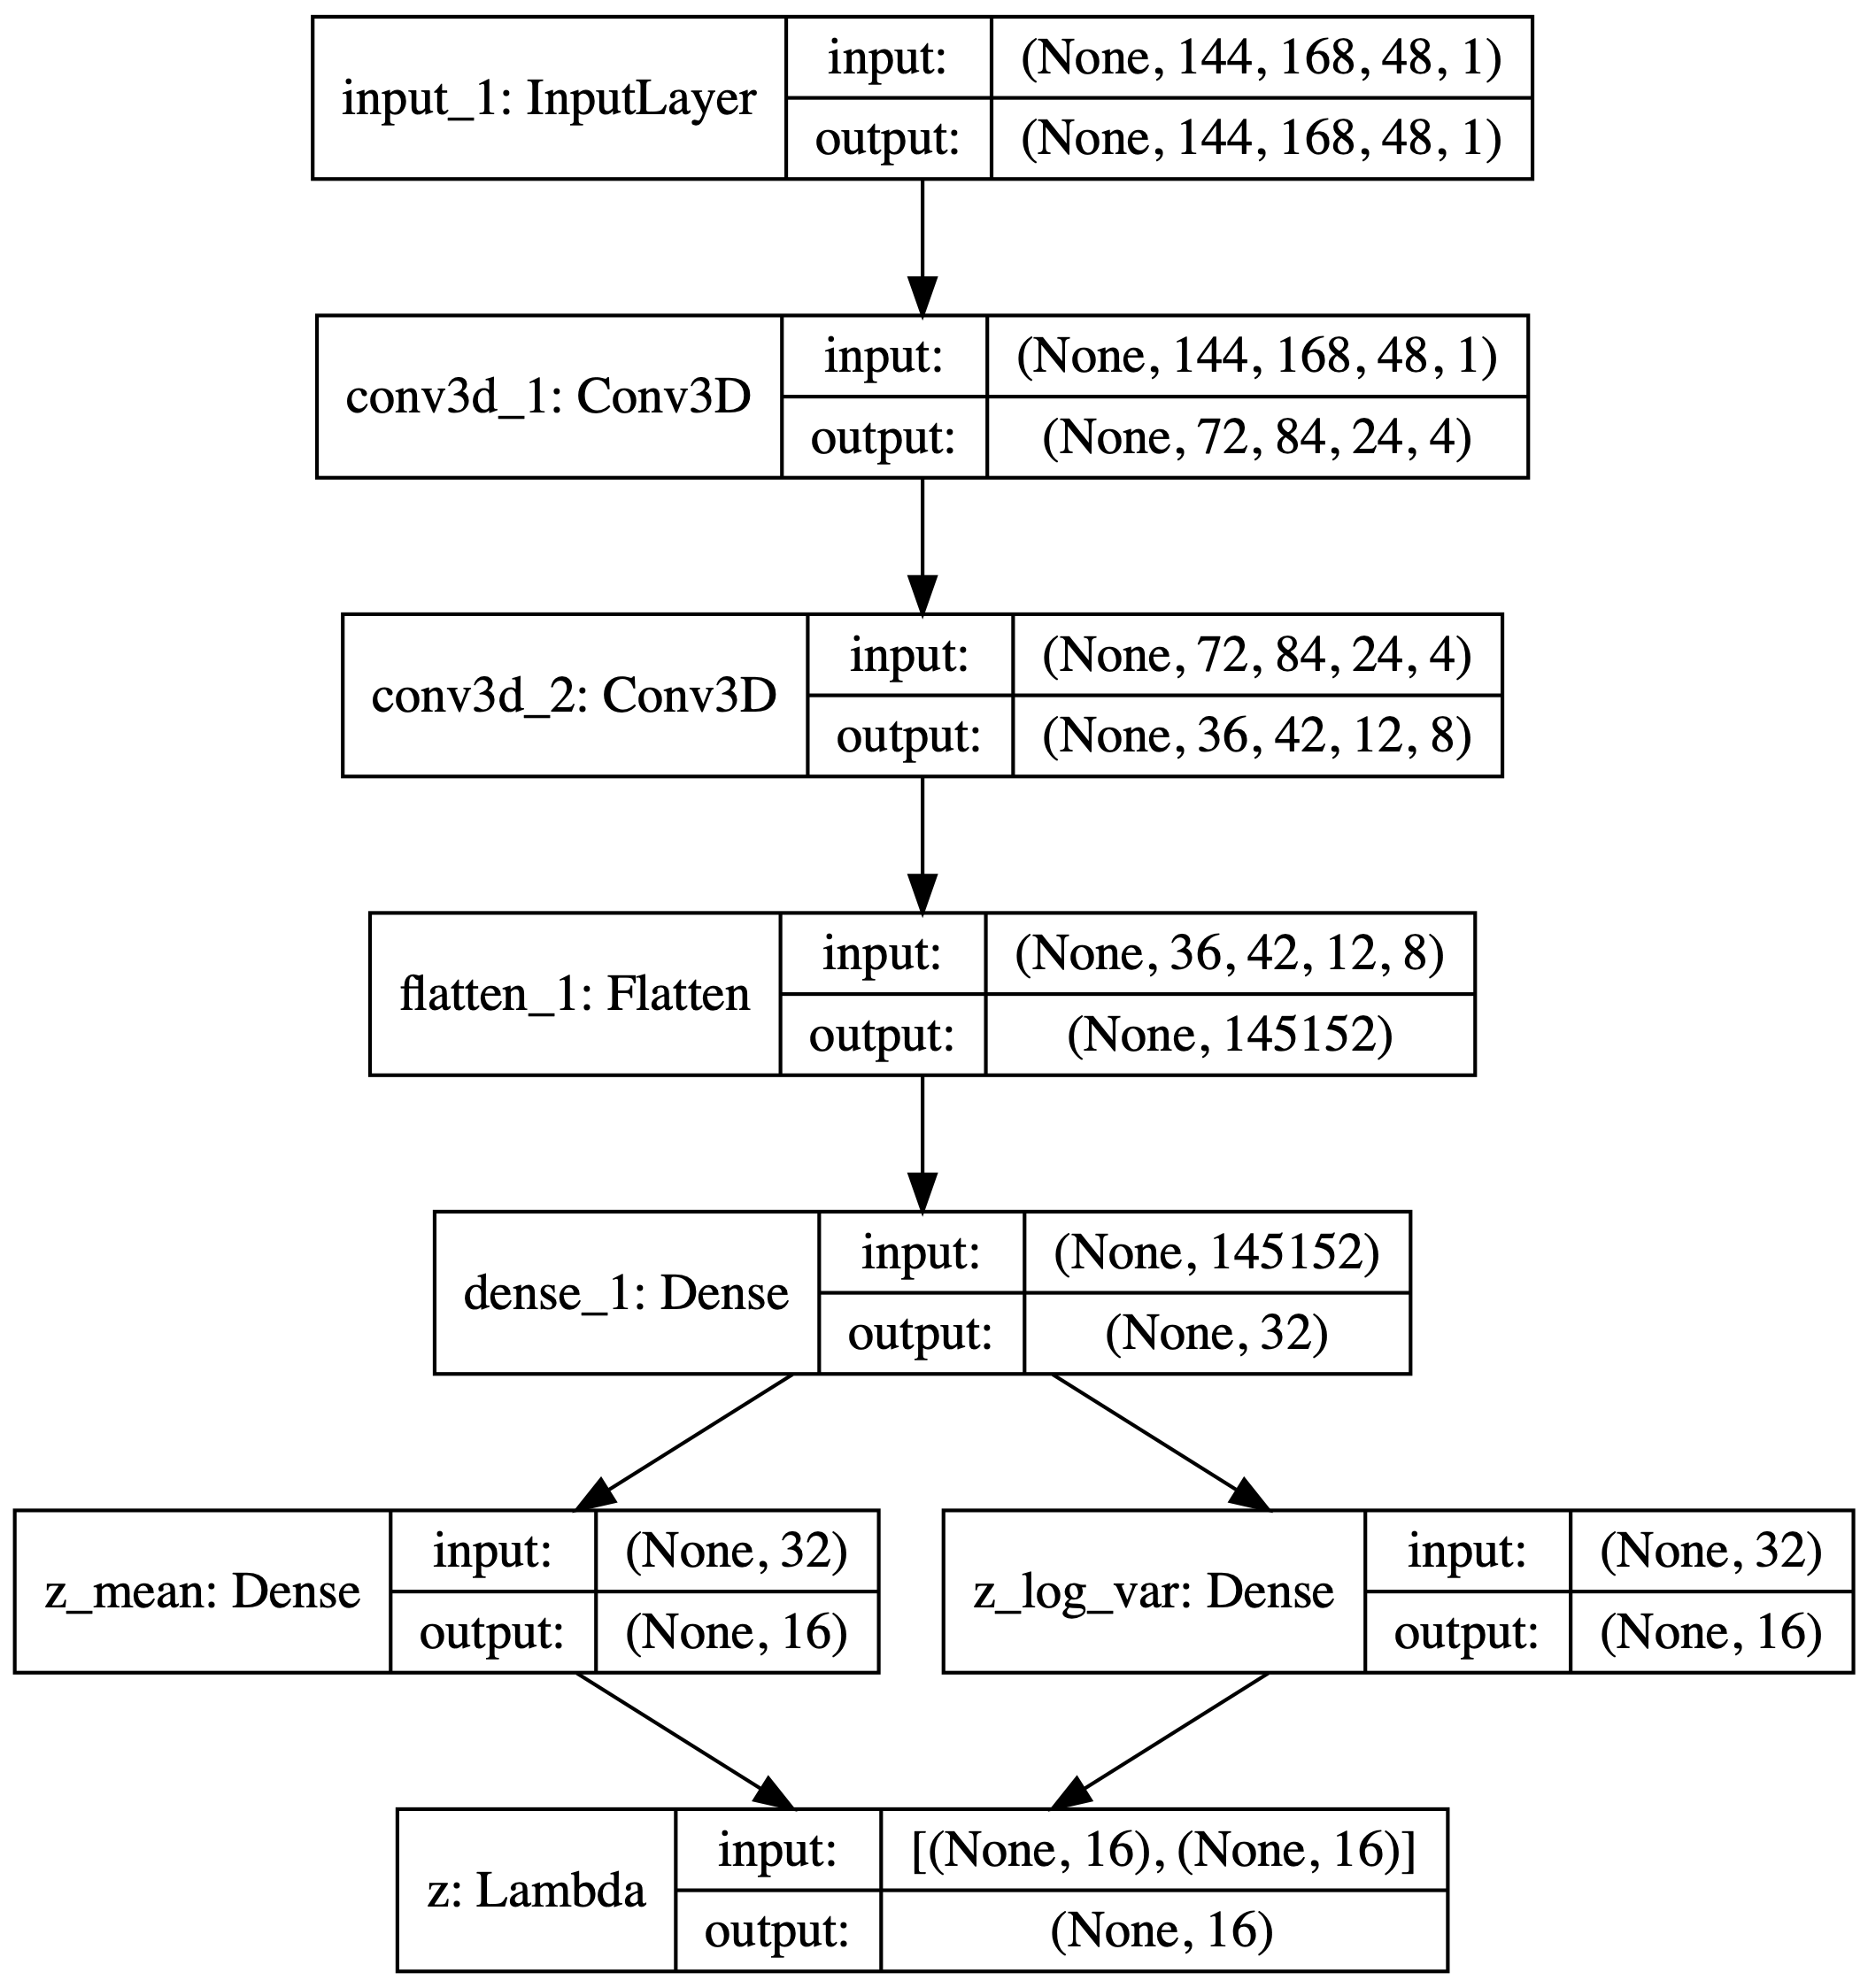

In [17]:
plot_model(encoder, show_shapes = True, dpi = 300)

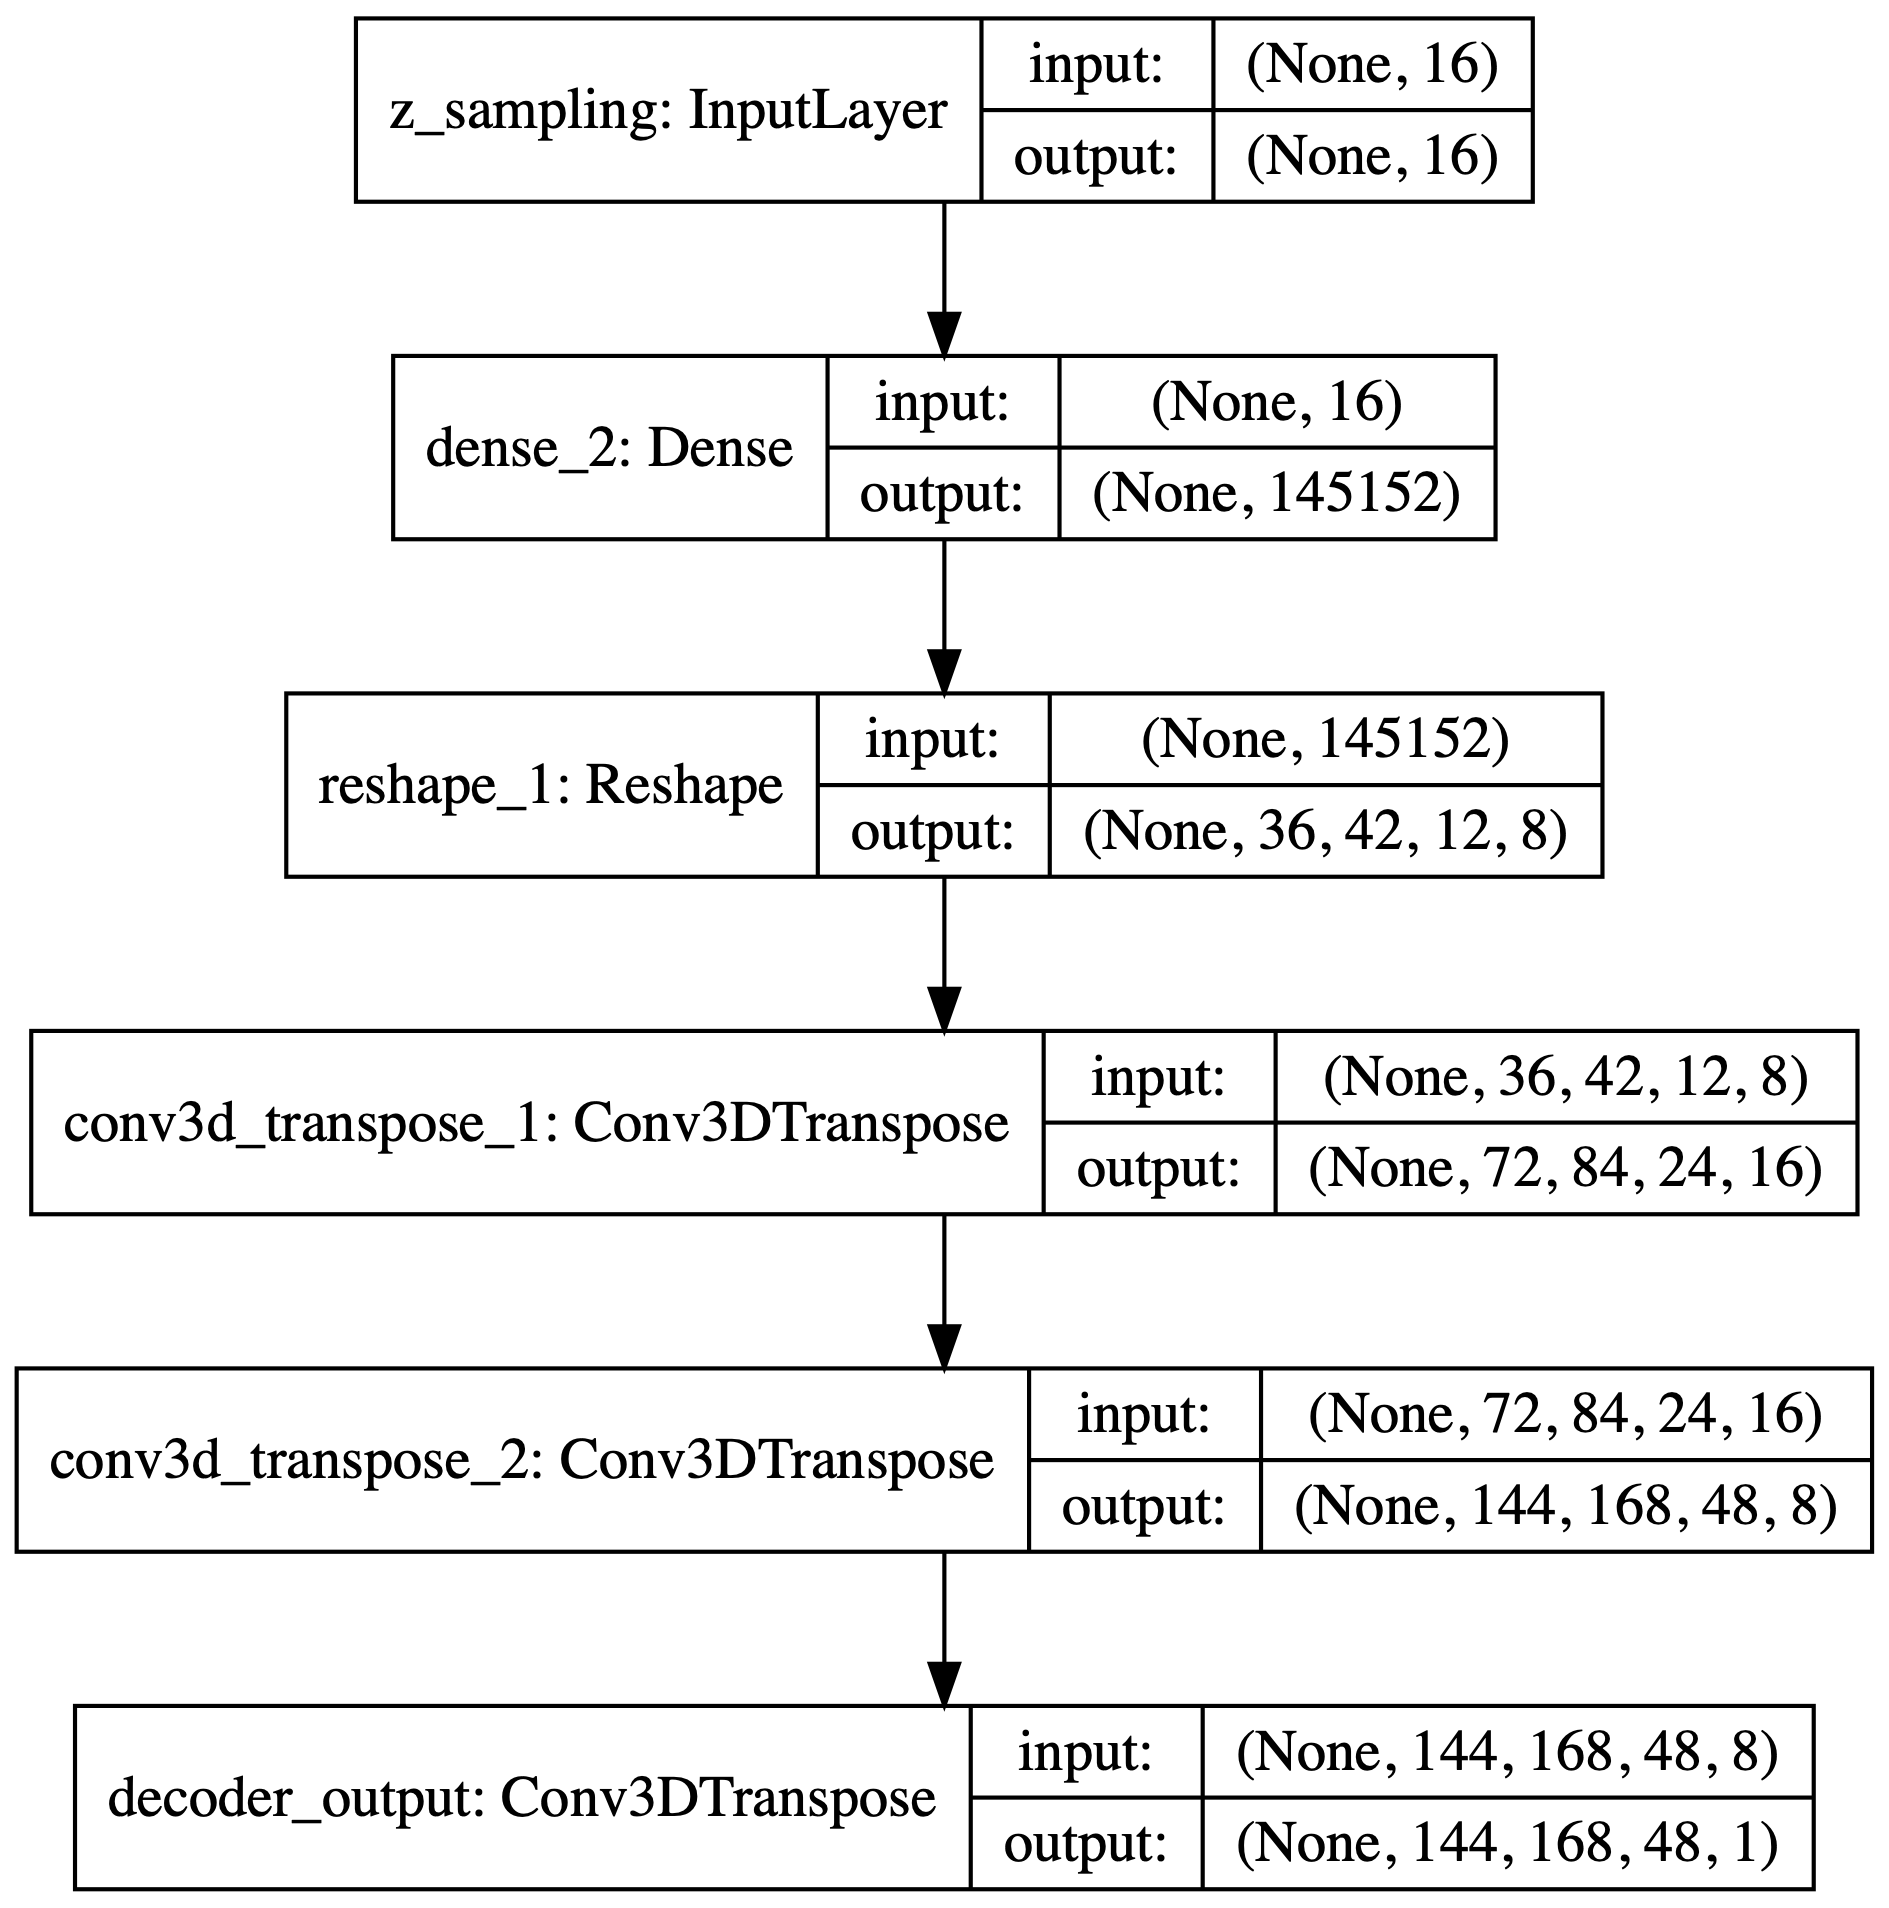

In [16]:
plot_model(decoder, show_shapes = True, dpi=300)

#### Train the model

In [16]:
# Loss function
def kl_reconstruction_loss(true, pred):
    recon_loss = K.mean(binary_crossentropy(true,pred), axis=[1,2,3])
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis = -1)
    kl_loss *= -0.5
    return K.mean(recon_loss + kl_loss)

In [21]:
from keras.utils import multi_gpu_model

vae_parallel = multi_gpu_model(vae, gpus=2)

In [10]:
vae_parallel.compile(optimizer = 'rmsprop', loss = kl_reconstruction_loss)
vae_parallel.fit_generator(train_data_gen,
                  steps_per_epoch = train_steps,
                  epochs = 30,
                  validation_data = val_data_gen,
                  validation_steps = val_steps,
                  verbose = 1)

Epoch 1/30
  12/2500 [..............................] - ETA: 1:49:03 - loss: 0.6419

KeyboardInterrupt: 

In [19]:
vae_parallel.save_weights('vae3d_hcp.h5')
del vae_parallel

In [23]:
vae_parallel.load_weights('vae3d_hcp.h5')
vae_parallel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 144, 168, 48, 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 144, 168, 48, 0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 144, 168, 48, 0           input_1[0][0]                    
__________________________________________________________________________________________________
vae (Model)                     (None, 144, 168, 48, 7121673     lambda_1[0][0]                   
                                                                 lambda_2[0][0]             